# <<< Imports >>>

In [95]:
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import (
    Dataset,
    DataLoader,
)

from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    RandomResizedCrop,
    RandomHorizontalFlip,
    ColorJitter,
    RandomGrayscale,
    RandomApply,
    Compose,
    GaussianBlur,
    ToTensor,
)
import torchvision.models as models

import os
import glob
import time
from skimage import io
import matplotlib.pyplot as plt

In [96]:
print(f'Torch-Version {torch.__version__}')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {DEVICE}')

Torch-Version 1.10.1
DEVICE: cpu


# Stochastic Augmentation Module


In this section we will talk about the data pipeline. The authors suggest that a strong data augmentation is useful for unsupervised learning. The following augmentation are suggested by the authors:

Random Crop with Resize
Random Horizontal Flip with 50% probability
Random Color Distortion
Random Color Jitter with 80% probability
Random Color Drop with 20% probability
Random Gaussian Blur with 50% probability

In [97]:
def get_complete_transform(output_shape, kernel_size, s=1.0):
    """
    The color distortion transform.

    Args:
        s: Strength parameter.

    Returns:
        A color distortion transform.
    """
    rnd_crop = RandomResizedCrop(output_shape)
    rnd_flip = RandomHorizontalFlip(p=0.5)

    color_jitter = ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = RandomApply([color_jitter], p=0.8)

    rnd_gray = RandomGrayscale(p=0.2)
    gaussian_blur = GaussianBlur(kernel_size=kernel_size)
    rnd_gaussian_blur = RandomApply([gaussian_blur], p=0.5)
    to_tensor = ToTensor()
    image_transform = Compose([
        to_tensor,
        rnd_crop,
        rnd_flip,
        rnd_color_jitter,
        rnd_gray,
        rnd_gaussian_blur,
    ])
    return image_transform


In [98]:
class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        views = [self.base_transform(x) for i in range(self.n_views)]
        return views

# Prepare the Data


In [99]:
class CustomDataset(Dataset):
    """Flowers Dataset"""

    def __init__(self, list_images, transform=None):
        """
        Args:
            list_images (list): List of all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_images = list_images
        self.transform = transform

    def __len__(self):
        return len(self.list_images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.list_images[idx]
        image = io.imread(img_name)
        if self.transform:
            image = self.transform(image)

        return image


In [100]:
# The size of the images
output_shape = [224,224]
kernel_size = [21,21] # 10% of the output_shape

# The custom transform
base_transforms = get_complete_transform(output_shape=output_shape,
kernel_size=kernel_size, s=1.0)
custom_transform = ContrastiveLearningViewGenerator(base_transform=base_transforms)

flowers_ds = CustomDataset(
    list_images=glob.glob('/Users/hafeez/Desktop/U-NET_nifti_reading/covid19-ct-scans/dataset/train/images/*'),
    #("/kaggle/input/flowers-recognition/flowers/flowers/*/*.jpg"),
    transform=custom_transform
)

# Visualise the data pipeline


2581


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


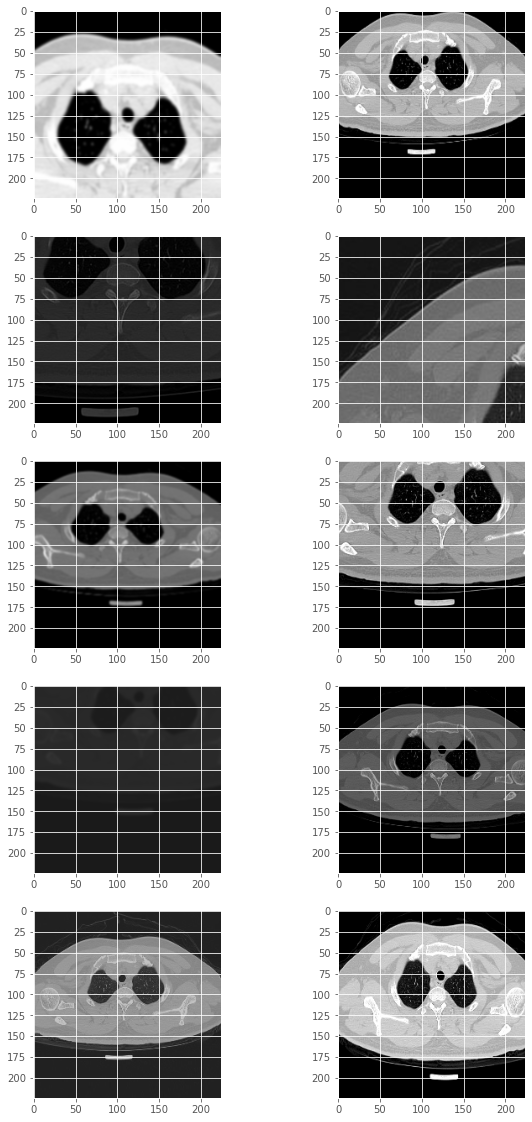

In [101]:
print(flowers_ds.__len__())
plt.figure(figsize=(10,20))

def view_data(flowers, index):
    for i in range(1,6):
        images = flowers[index]
        view1, view2 = images
        plt.subplot(5,2,2*i-1)
        plt.imshow(view1.permute(1,2,0))
        plt.subplot(5,2,2*i)
        plt.imshow(view2.permute(1,2,0))

view_data(flowers_ds,3)


In [102]:
BATCH_SIZE = 128

# Building the data loader
train_dl = torch.utils.data.DataLoader(
    flowers_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    drop_last=True,
    pin_memory=True,
)
print(len(train_dl))

20


# SimCLR Model


In [103]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

In [104]:
class SimCLR(nn.Module):
    def __init__(self, linear_eval=False):
        super().__init__()
        self.linear_eval = linear_eval
        resnet18 = models.resnet18(pretrained=False)
        resnet18.fc = Identity()
        self.encoder = resnet18
        self.projection = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256)
        )
        
    def forward(self, x):
        if not self.linear_eval:
            x = torch.cat(x, dim=0)

        encoding = self.encoder(x)
        projection = self.projection(encoding)
        return projection



# Contrastive Loss



The loss function is basically built on top of two things:

softmax
cosine similarity

In [105]:
LABELS = torch.cat([torch.arange(BATCH_SIZE) for i in range(2)], dim=0)
LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float() 
#Creates a one-hot with broadcasting
LABELS = LABELS.to(DEVICE) #128,128

In [106]:
def cont_loss(features, temp):
    """
    The NTxent Loss.

    Args:
        z1: The projection of the first branch
        z2: The projeciton of the second branch

    Returns:
        the NTxent loss
    """
    similarity_matrix = torch.matmul(features, features.T) # 128, 128
    # discard the main diagonal from both: labels and similarities matrix
    mask = torch.eye(LABELS.shape[0], dtype=torch.bool).to(DEVICE)
    # ~mask is the negative of the mask
    # the view is required to bring the matrix back to shape
    labels = LABELS[~mask].view(LABELS.shape[0], -1) # 128, 127
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1) # 128, 127

    # select and combine multiple positives
    positives = similarity_matrix[labels.bool()].view(labels.shape[0],-1) # 128, 1

    # select only the negatives
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1) # 128, 126

    logits = torch.cat([positives, negatives], dim=1) # 128, 127
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(DEVICE)

    logits = logits / temp
    return logits, labels



In [107]:
simclr_model = SimCLR().to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(simclr_model.parameters())


In [108]:
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}

In [114]:
EPOCHS = 10
for epoch in range(EPOCHS):
    t0 = time.time()
    running_loss = 0.0
    print (epoch)
    for i, views in enumerate(train_dl):
        projections = simclr_model([view.to(DEVICE) for view in views])
        logits, labels = cont_loss(projections, temp=2)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print (i)

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print(f'EPOCH: {epoch+1} BATCH: {i+1} LOSS: {(running_loss/100):.4f} ')
            H["train_loss"].append(running_loss/100)
            running_loss = 0.0
            print(f'Time taken: {((time.time()-t0)/60):.3f} mins')
            


0
0
1
2
3
4
5
6
7
8
9
EPOCH: 1 BATCH: 10 LOSS: 0.5372 
Time taken: 15.717 mins
10
11
12
13
14
15
16
17
18
19
EPOCH: 1 BATCH: 20 LOSS: 0.5279 
Time taken: 31.187 mins
1
0
1
2
3
4
5
6
7
8
9
EPOCH: 2 BATCH: 10 LOSS: 0.5242 
Time taken: 15.558 mins
10
11
12
13
14
15
16
17
18
19
EPOCH: 2 BATCH: 20 LOSS: 0.5196 
Time taken: 31.061 mins
2
0
1
2
3
4
5
6
7
8
9
EPOCH: 3 BATCH: 10 LOSS: 0.5157 
Time taken: 15.553 mins
10
11
12
13
14
15
16
17
18
19
EPOCH: 3 BATCH: 20 LOSS: 0.5102 
Time taken: 31.002 mins
3
0
1
2
3
4
5
6
7
8
9
EPOCH: 4 BATCH: 10 LOSS: 0.5027 
Time taken: 15.491 mins
10
11
12
13
14
15
16
17
18
19
EPOCH: 4 BATCH: 20 LOSS: 0.4998 
Time taken: 30.909 mins
4
0
1
2
3
4
5
6
7
8
9
EPOCH: 5 BATCH: 10 LOSS: 0.4927 
Time taken: 15.430 mins
10
11
12
13
14
15
16
17
18
19
EPOCH: 5 BATCH: 20 LOSS: 0.4892 
Time taken: 30.839 mins
5
0
1
2
3
4
5
6
7
8
9
EPOCH: 6 BATCH: 10 LOSS: 0.4854 
Time taken: 15.396 mins
10
11
12
13
14
15
16
17
18
19
EPOCH: 6 BATCH: 20 LOSS: 0.4755 
Time taken: 30.771 mins
6
0


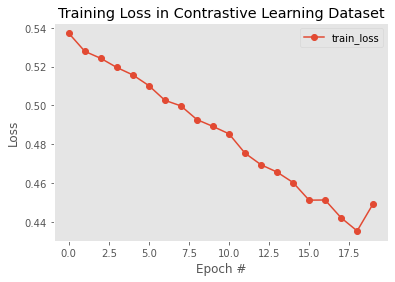

In [115]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss", marker="o")
plt.title("Training Loss in Contrastive Learning Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.legend() 
plt.grid()
#plt.savefig(config.LOSS_PLOT_PATH)

# Down Stream Task

Down Stream Task
After we have a trained SimCLR model we will discard the projection head and use the encoder only. We provide a Centre Cropped image to the encoder and get a learned representation of the images. This representation is then used in down stream tasks like classification.

In [138]:
from torchvision.transforms import (
    CenterCrop,
    Resize
)

resize = Resize(255)
ccrop = CenterCrop(224)
ttensor = ToTensor()

custom_transform = Compose([ resize, ccrop, ttensor])

covid_ds = ImageFolder(root='./img/', transform=custom_transform)


nu_classes = len(flowers_ds.classes)

BATCH_SIZE = 128
print(covid_ds)
print(nu_classes)

# Building the data loader
train_dl = torch.utils.data.DataLoader(
    covid_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    drop_last=True,
    pin_memory=True,
)

print("covid dataset contains {} samples...".format(
        len(covid_ds)))
print("[INFO] training dl contains {} samples...".format(
        len(train_dl)))

Dataset ImageFolder
    Number of datapoints: 2581
    Root location: ./img/
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
           )
1
covid dataset contains 2581 samples...
[INFO] training dl contains 20 samples...


In [139]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

In [140]:
class LinearEvaluation(nn.Module):
    def __init__(self, model, nu_classes):
        super().__init__()
        simclr = model
        simclr.linear_eval = True
        simclr.projection = Identity()
        self.simclr = simclr
        for param in self.simclr.parameters():
            param.requires_grad = False
        self.linear = nn.Linear(512, nu_classes)
    def forward(self, x):
        encoding = self.simclr(x)
        pred = self.linear(encoding)
        return pred

eval_model = LinearEvaluation(simclr_model, nu_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(eval_model.parameters())

In [141]:
EPOCHS = 10
for epoch in range(EPOCHS):
    t0 = time.time()
    running_loss = 0.0
    for i, element in enumerate(train_dl):
    #for i, (image, label) in enumerate(flowers_ds):
        image, label = element
        #image = image.to(DEVICE)
        #label = label.to(DEVICE)
        pred = eval_model(image)
        loss = criterion(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print(f'EPOCH: {epoch+1} BATCH: {i+1} LOSS: {(running_loss/100):.4f} ')
            running_loss = 0.0
    print(f'Time taken: {((time.time()-t0)/60):.3f} mins')

EPOCH: 1 BATCH: 10 LOSS: 0.0000 
EPOCH: 1 BATCH: 20 LOSS: 0.0000 
Time taken: 5.255 mins
EPOCH: 2 BATCH: 10 LOSS: 0.0000 
EPOCH: 2 BATCH: 20 LOSS: 0.0000 
Time taken: 4.418 mins
EPOCH: 3 BATCH: 10 LOSS: 0.0000 
EPOCH: 3 BATCH: 20 LOSS: 0.0000 
Time taken: 4.412 mins
EPOCH: 4 BATCH: 10 LOSS: 0.0000 
EPOCH: 4 BATCH: 20 LOSS: 0.0000 
Time taken: 4.404 mins
EPOCH: 5 BATCH: 10 LOSS: 0.0000 
EPOCH: 5 BATCH: 20 LOSS: 0.0000 
Time taken: 4.394 mins
EPOCH: 6 BATCH: 10 LOSS: 0.0000 
EPOCH: 6 BATCH: 20 LOSS: 0.0000 
Time taken: 4.431 mins
EPOCH: 7 BATCH: 10 LOSS: 0.0000 
EPOCH: 7 BATCH: 20 LOSS: 0.0000 
Time taken: 4.399 mins
EPOCH: 8 BATCH: 10 LOSS: 0.0000 
EPOCH: 8 BATCH: 20 LOSS: 0.0000 
Time taken: 4.390 mins
EPOCH: 9 BATCH: 10 LOSS: 0.0000 
EPOCH: 9 BATCH: 20 LOSS: 0.0000 
Time taken: 4.386 mins
EPOCH: 10 BATCH: 10 LOSS: 0.0000 
EPOCH: 10 BATCH: 20 LOSS: 0.0000 
Time taken: 4.398 mins
